In [26]:
import os
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import math
from seaborn import heatmap
from matplotlib import transforms

In [27]:
def importAudio(target, reference, output=True):
    if(output):
        display(ipd.Audio(target))
        display(ipd.Audio(reference))

    tArray, tSampleRate = librosa.load(target)
    rArray, rSampleRate = librosa.load(reference)

    tSTFT = librosa.stft(tArray, n_fft=frameSize, hop_length=hopSize)
    rSTFT = librosa.stft(rArray, n_fft=frameSize, hop_length=hopSize)

    tDFT = librosa.stft(tArray, n_fft=frameSize, hop_length=10000000000)
    rDFT = librosa.stft(rArray, n_fft=frameSize, hop_length=10000000000)
    
    return ({"STFT":tSTFT,"DFT":tDFT,"sampleRate":tSampleRate},{"STFT":rSTFT,"DFT":rDFT,"sampleRate":rSampleRate})

In [28]:
def exportAudio(tAudio, mAudio, rAudio):
    print("Target")
    tInverse = librosa.istft(tAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(tInverse, rate=tAudio["sampleRate"]))

    print("Matched")
    mInverse = librosa.istft(mAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(mInverse, rate=mAudio["sampleRate"]))

    print("Reference")
    rInverse = librosa.istft(rAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(rInverse, rate=rAudio["sampleRate"]))

In [29]:
def plotSpectrogram(tAudio, mAudio, rAudio):

    maximum = (max(np.max(np.abs(tAudio["STFT"])**2), np.max(np.abs(rAudio["STFT"])**2)))
    
    # derives the spectrogram from the STFT
    tSpectrogram = librosa.power_to_db(np.abs(tAudio["STFT"])**2, ref=np.max)
    mSpectrogram = librosa.power_to_db(np.abs(mAudio["STFT"])**2, ref=np.max)
    rSpectrogram = librosa.power_to_db(np.abs(rAudio["STFT"])**2, ref=np.max)

    # creates plots of spectrograms
    fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10*figScale, 5*figScale))
    tImg = librosa.display.specshow(tSpectrogram,sr=tAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[0])
    mImg = librosa.display.specshow(mSpectrogram,sr=mAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[1])
    rImg = librosa.display.specshow(rSpectrogram,sr=rAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[2])

    # adjusts appearance
    ax[0].set(title='Target')
    ax[1].set(title='Matched')
    ax[2].set(title='Reference')
    for ax_i in ax:
        ax_i.label_outer()
    fig.colorbar(mImg, ax=[ax[0], ax[1], ax[2]],format='%+2.0f dB')


<h3>Matching based on gain average of frequency bands</h3>

In [30]:
def plotCurve(tCurve,tCurveSmooth,rCurve,rCurveSmooth,mCurve):
    plt.figure(figsize=(10*figScale,5*figScale))

    plt.plot(20*np.log10(tCurve), alpha=0.2, color='blue', label="Target")
    plt.plot(20*np.log10(tCurveSmooth), color='blue', label="Convolved Target")

    plt.plot(20*np.log10(rCurve), alpha=0.2, color='red', label="Reference")
    plt.plot(20*np.log10(rCurveSmooth), color='red', label="Convolved Reference")

    plt.plot(20*np.log10(mCurve), color='green', label="Matched")
    
    plt.xlabel("Frequency Bin")
    plt.ylabel("Gain (dB)")
    plt.legend()

In [31]:
def convolve(curve, smoothing):
    curve = np.ravel(curve)
    kernel = np.ones(smoothing) / smoothing
    curve = np.convolve(curve, kernel, mode='same')
    curve = curve.reshape(len(curve),1)
    return curve

def EQMatching(tAudio, rAudio, smoothing=1, plot=True):
    tCurve = np.abs(tAudio["DFT"])
    tCurveSmooth = convolve(tCurve, smoothing)

    rCurve = np.abs(rAudio["DFT"])
    rCurveSmooth = convolve(rCurve, smoothing)

    scaler = rCurveSmooth / tCurveSmooth
    
    mSTFT = tAudio["STFT"] * scaler
    mDFT = tAudio["DFT"] * scaler
    mAudio = {"STFT":mSTFT,"DFT":mDFT,"sampleRate":tAudio["sampleRate"]}

    if(plot):
        mCurve = np.abs(mDFT)
        plotCurve(tCurve,tCurveSmooth,rCurve,rCurveSmooth,mCurve)
    
    return mAudio

In [32]:
def dynamicMatching(tAudio,rAudio,dynamicBins):
    freqBinNum = 100

    # Frequency slice- showing the changes in gain over time for target and reference
    freqBin = (20*np.log10(np.abs(tAudio["STFT"][freqBinNum,:])), 20*np.log10(np.abs(rAudio["STFT"][freqBinNum,:])))
    # The minimum and maximum gain values across target and reference combined
    dynamicRange = (min(min(freqBin[0]),min(freqBin[1])), max(max(freqBin[0]),max(freqBin[1])))
    # Histograms of how commonly certain gain ranges occur within the target and refernce audio
    dynamicResponse = (np.histogram(freqBin[0],bins=dynamicBins,range=dynamicRange)[0], np.histogram(freqBin[1],bins=dynamicBins,range=dynamicRange)[0])

    # The minimum and maximum amount of gain range occurrence across target and reference combined
    # occurrenceRange = (min(min(dynamicResponse[0]),min(dynamicResponse[1])),max(max(dynamicResponse[0]),max(dynamicResponse[1])))

    fig, ax = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='col', figsize=(10*figScale, 5*figScale), gridspec_kw={'width_ratios': [8, 1]})
    
    for i in range(2):
        ax[i,0].plot(freqBin[i])
        
        tr = transforms.Affine2D().rotate_deg(90)
        reshape = np.flip(dynamicResponse[i].reshape(dynamicResponse[i].shape[0], 1))
        sns = heatmap(reshape, ax=ax[i,1], cmap="magma")
        ax[i,1].set_xticks([])
        ax[i,1].set_yticks([])
        ax[i,0].set_ylabel("Gain (dB)")
        ax[i,0].set_xlabel("Frame")
        fig.tight_layout(rect=[0, 0, .9, 1])
    
    # adjusts appearance
    for ax_i in ax:
        ax_i[0].label_outer()
    ax[0,0].set(title='Target')
    ax[1,0].set(title='Reference')


In [ ]:
def test1():
    return 0

def test2():
    num = test1()
    

In [65]:
# Plots a given frequency bin of target, matched, and reference audio, along with its dynamic response historgram
def plotDynamics(tAudio, mAudio, rAudio, dynamicBins, plotBin):

    # frequency bin plotted in dB
    tdB = 20*np.log10(np.abs(tAudio["STFT"][plotBin,:]))
    mdB = 20*np.log10(np.abs(mAudio["STFT"][plotBin,:]))
    rdB = 20*np.log10(np.abs(rAudio["STFT"][plotBin,:]))

    # gets dynamic response historgram of target, matched, and reference
    (tDynamicResponse, rDynamicResponse) = getDynamicResponse(tAudio["STFT"][plotBin,:], rAudio["STFT"][plotBin,:], dynamicBins)
    (mDynamicResponse, rDynamicResponse) = getDynamicResponse(mAudio["STFT"][plotBin,:], rAudio["STFT"][plotBin,:], dynamicBins)

    dB = (tdB, mdB, rdB)
    dynamicResponse = (tDynamicResponse, mDynamicResponse, rDynamicResponse)

    # plot
    fig, ax = plt.subplots(nrows=3, ncols=2, sharex='col', sharey='col', figsize=(10*figScale, 5*figScale), gridspec_kw={'width_ratios': [8, 1]})
    
    for i in range(3):
        ax[i,0].plot(dB[i])
        
        tr = transforms.Affine2D().rotate_deg(90)
        reshape = np.flip(dynamicResponse[i].reshape(dynamicResponse[i].shape[0], 1))
        sns = heatmap(reshape, ax=ax[i,1], cmap="magma")
        ax[i,1].set_xticks([])
        ax[i,1].set_yticks([])
        ax[i,0].set_ylabel("Gain (dB)")
        ax[i,0].set_xlabel("Frame")
        fig.tight_layout(rect=[0, 0, .9, 1])
    
    # adjusts appearance
    for ax_i in ax:
        ax_i[0].label_outer()
    ax[0,0].set(title='Target')
    ax[1,0].set(title='Matched')
    ax[2,0].set(title='Reference')

In [68]:
def getDynamicResponse(tFreqBin, rFreqBin, dynamicBins):
    # Convert to dB
    tdB = 20*np.log10(np.abs(tFreqBin))
    rdB = 20*np.log10(np.abs(rFreqBin))

    # The minimum and maximum gain values across target and reference combined
    dynamicRange = (min(min(tdB),min(rdB)), max(max(tdB),max(rdB)))

    # Histograms of how commonly certain gain ranges occur, in dB
    tDynamicResponse = np.histogram(tdB,bins=dynamicBins,range=dynamicRange)[0]
    rDynamicResponse = np.histogram(rdB,bins=dynamicBins,range=dynamicRange)[0]

    return (tDynamicResponse, rDynamicResponse)

def match(tAudio, rAudio, dynamicBins):
    return tAudio

def dynamicMatching(tAudio,rAudio,dynamicBins, plotBin):
    mAudio = match(tAudio, rAudio, dynamicBins)

    plotDynamics(tAudio, mAudio, rAudio, dynamicBins, plotBin)

    return mAudio


<h1>Execution</h1>

In [34]:
frameSize=2048
hopSize=512

figScale = 1

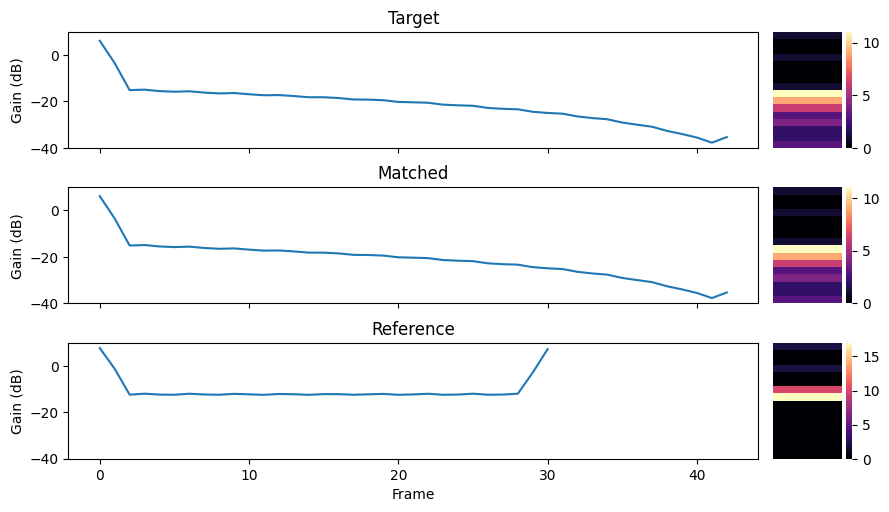

In [67]:
#tAudio, rAudio = importAudio(target="audio_mono.wav",reference="audo3_mono.wav", output=False)
tAudio, rAudio = importAudio(target="tone1.wav",reference="tone2loud.wav", output=True)

mAudio = dynamicMatching(tAudio,rAudio,dynamicBins=16, plotBin=100)

#mAudio = EQMatching(tAudio,rAudio,smoothing=1, plot=True)

#dynamicMatching(mAudio,rAudio,dynamicBins=16)

#plotSpectrogram(tAudio, mAudio, rAudio)

In [ ]:
exportAudio(tAudio, mAudio, rAudio)

Target


Matched


Reference
